# Example optimisation with stochastic nonlocal modifications and gradient descent

## Imports

In [1]:
import seaborn as sns

In [2]:
from ship_routing.core import Route, WayPoint
from ship_routing.data import (
    load_currents,
    load_winds,
    load_waves,
)
from ship_routing.algorithms import (
    gradient_descent_across_track_left,
    gradient_descent_along_track,
    gradient_descent_time_shift,
    LargeIncrementError,
    InvalidGradientError,
    ZeroGradientsError,
)

In [3]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from copy import deepcopy
import tqdm
from random import choice

## Parameters

In [4]:
np.random.seed(345)
population_size = 100
target_acceptance_fraction = 1 / 30.0
reproduction_fraction = 1.0
num_generations = 5

## Load and plot currents, winds, waves

In [5]:
currents = load_currents(
    data_file="data/currents/cmems_mod_glo_phy-cur_anfc_0.083deg_P1D-m_2021-01_100W-020E_10N-65N.nc"
)
currents["speed"] = ((currents.to_array() ** 2).sum("variable") ** 0.5).where(
    ~currents.uo.isnull()
)

currents

<xarray.Dataset> Size: 10MB
Dimensions:  (lat: 661, lon: 1321, time: 1)
Coordinates:
    depth    float32 4B ...
  * lat      (lat) float32 3kB 10.0 10.08 10.17 10.25 ... 64.75 64.83 64.92 65.0
  * lon      (lon) float32 5kB -100.0 -99.92 -99.83 -99.75 ... 9.833 9.917 10.0
  * time     (time) datetime64[ns] 8B 2021-01-01
Data variables:
    uo       (time, lat, lon) float32 3MB -0.1356 -0.1479 ... 0.07963 0.05846
    vo       (time, lat, lon) float32 3MB -0.01258 -0.02277 ... 0.2739 0.4073
    speed    (time, lat, lon) float32 3MB 0.1362 0.1497 0.163 ... 0.2852 0.4115
Attributes:
    Conventions:  CF-1.8
    area:         Global
    contact:      https://marine.copernicus.eu/contact
    credit:       E.U. Copernicus Marine Service Information (CMEMS)
    institution:  Mercator Ocean International
    licence:      http://marine.copernicus.eu/services-portfolio/service-comm...
    producer:     CMEMS - Global Monitoring and Forecasting Centre
    references:   http://marine.copernicus.eu
    source:       MOI GLO12
    title:        daily mean fields from Global Ocean Physics Analysis and Fo...

In [6]:
winds = load_winds(
    data_file="data/winds/cmems_obs-wind_glo_phy_my_l4_0.125deg_PT1H_2021-01_6hours_0.5deg_100W-020E_10N-65N.nc"
)
winds["speed"] = ((winds.to_array() ** 2).sum("variable") ** 0.5).where(
    ~winds.uw.isnull()
)
winds

<xarray.Dataset> Size: 26MB
Dimensions:  (time: 125, lat: 110, lon: 160)
Coordinates:
  * lat      (lat) float32 440B 10.06 10.56 11.06 11.56 ... 63.56 64.06 64.56
  * lon      (lon) float32 640B -99.94 -99.44 -98.94 ... -21.44 -20.94 -20.44
  * time     (time) datetime64[ns] 1kB 2021-01-01 ... 2021-02-01
Data variables:
    uw       (time, lat, lon) float32 9MB 1.77 2.06 1.19 ... -1.06 -0.82 -0.7
    vw       (time, lat, lon) float32 9MB -3.44 -3.66 -4.05 ... 0.15 0.1 -0.26
    speed    (time, lat, lon) float32 9MB 3.869 4.2 4.221 ... 0.8261 0.7467
Attributes: (12/26)
    Conventions:                CF-1.6, ACDD-1.3
    date_created:               2024-03-25T23:58:22
    date_modified:              2024-03-25T23:58:22
    geospatial_lat_max:         89.9375
    geospatial_lat_min:         -89.9375
    geospatial_lat_resolution:  0.125
    ...                         ...
    project:                    Copernicus Marine Service Wind Thematic Assem...
    references:                 Copernicus Marine Service Product User Manual...
    summary:                    Global ocean 10-m stress-equivalent wind and ...
    time_coverage_end:          2023-12-21T23:00:00
    time_coverage_start:        2023-12-21T23:00:00
    title:                       Global Ocean - Wind and Stress - Hourly - Re...

In [7]:
waves = load_waves(
    data_file="data/waves/cmems_mod_glo_wav_my_0.2deg_PT3H-i_VHM0_2021-01_1d-max_100W-020E_10N-65N.nc"
)

# waves["wh"] = waves["wh"] * 0.75

waves

<xarray.Dataset> Size: 14MB
Dimensions:  (lat: 276, lon: 401, time: 32)
Coordinates:
  * lat      (lat) float32 1kB 10.0 10.2 10.4 10.6 10.8 ... 64.4 64.6 64.8 65.0
  * lon      (lon) float32 2kB -100.0 -99.8 -99.6 -99.4 ... -20.4 -20.2 -20.0
  * time     (time) datetime64[ns] 256B 2001-01-01T12:00:00 ... 2001-02-01T12...
Data variables:
    wh       (time, lat, lon) float32 14MB ...

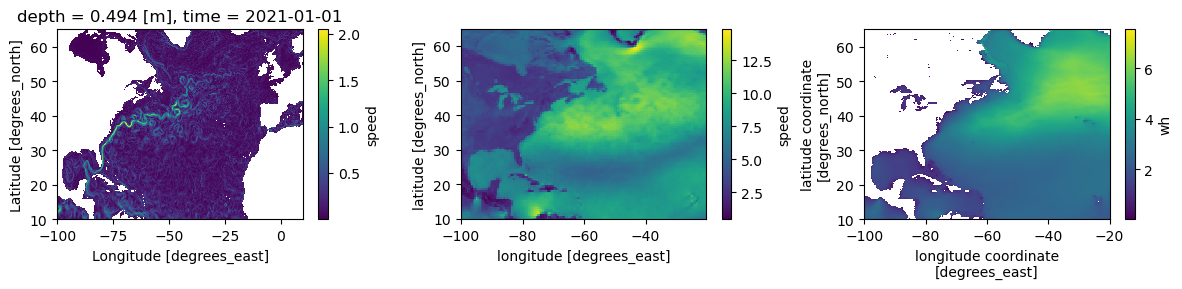

In [8]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

fig.tight_layout();

## Define a route and have a look

Route departs close to the Gulf Stream and arrives close to Great Britain. This way, we may be able to surf the Gulf Stream for reducing fuel.

In [9]:
route_0 = Route(
    way_points=(
        WayPoint(lon=-80.5, lat=30, time=np.datetime64("2021-01-01")),
        WayPoint(lon=-25, lat=45, time=np.datetime64("2021-01-04")),
    )
)
# refine to 3 hourly way points
refine_to = np.mean([l.speed_ms for l in route_0.legs]) * 3 * 3600.0
route_0 = route_0.refine(distance_meters=refine_to)
route_0

Route(way_points=(WayPoint(lon=-80.5, lat=30, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.68969695618517, lat=31.086742127247746, time=numpy.datetime64('2021-01-01T02:59:59.999')), WayPoint(lon=-76.83822880833705, lat=32.14730912624545, time=numpy.datetime64('2021-01-01T05:59:59.999')), WayPoint(lon=-74.94396975655307, lat=33.17999101970091, time=numpy.datetime64('2021-01-01T08:59:59.999')), WayPoint(lon=-73.00540106654056, lat=34.18300911191114, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-71.02113998429357, lat=35.154517921716774, time=numpy.datetime64('2021-01-01T14:59:59.999')), WayPoint(lon=-68.98997205901848, lat=36.09260854850424, time=numpy.datetime64('2021-01-01T17:59:59.999')), WayPoint(lon=-66.91088670769119, lat=36.995313696971735, time=numpy.datetime64('2021-01-01T20:59:59.999')), WayPoint(lon=-64.78311566868122, lat=37.860614586725035, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-62.60617376616913, lat=38.686449961712015,

In [10]:
print("speed (m/s)", np.mean([l.speed_ms for l in route_0.legs]))
print("speed (knots)", np.mean([l.speed_ms / 1.94 for l in route_0.legs]))

speed (m/s) 19.57356243489512
speed (knots) 10.08946517262635


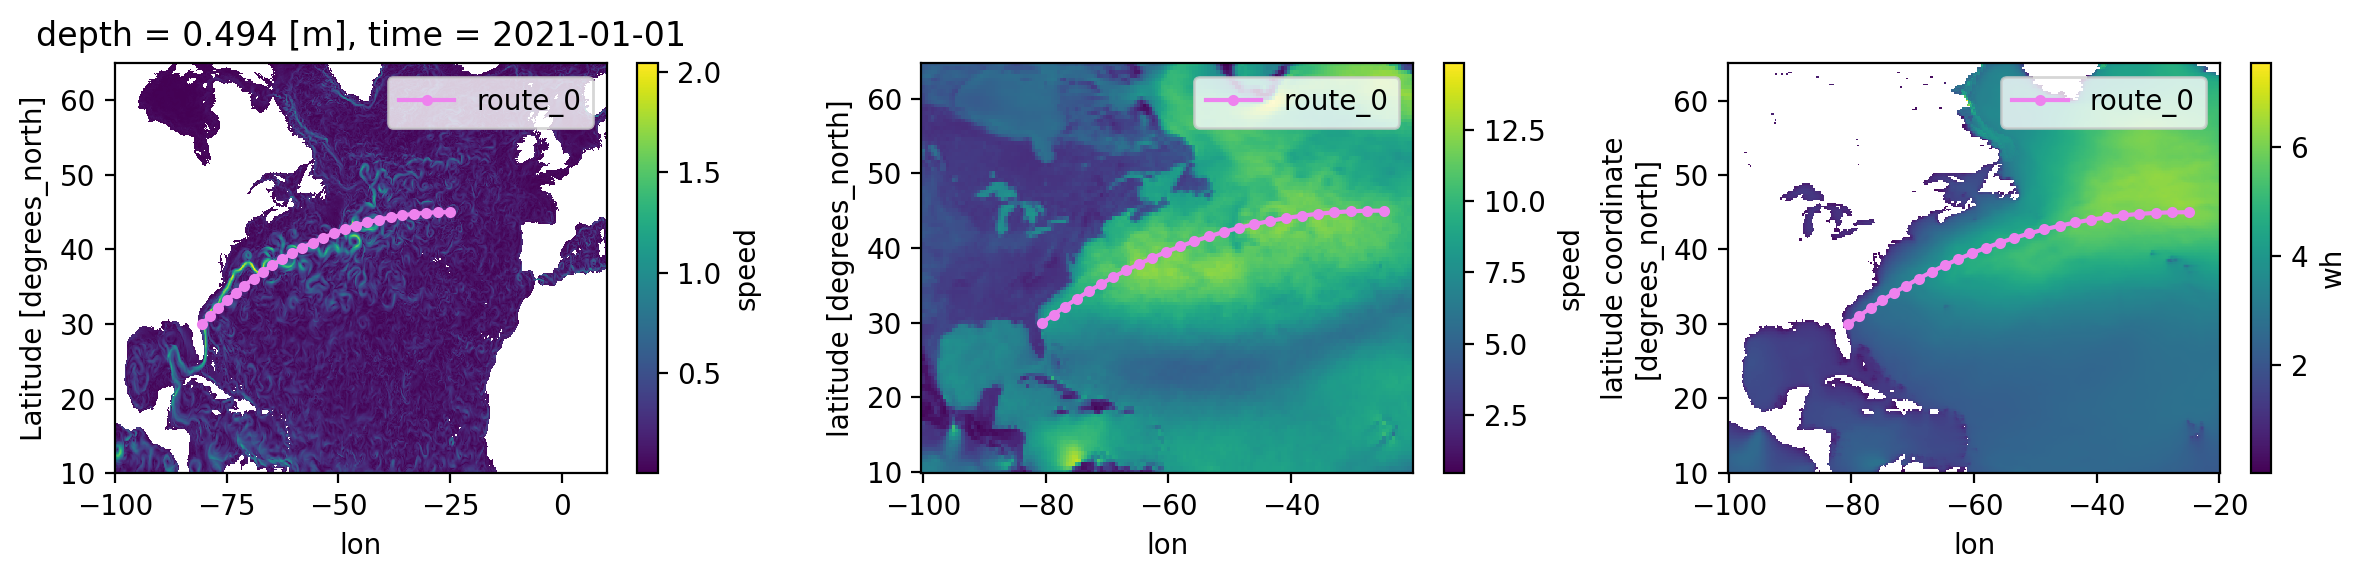

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 3))

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax.flatten():
    route_0.data_frame.plot.line(
        x="lon", y="lat", marker=".", ax=_ax, color="violet", label="route_0"
    )

fig.tight_layout();

## Replicate route to a population

In [12]:
# note that as Route is immutable, this is safe...
routes = [route_0 for n in range(population_size)]
cost_0 = route_0.cost_through(
    current_data_set=currents,
    wave_data_set=waves,
    wind_data_set=winds,
)
costs = [cost_0 for n in range(population_size)]

## Genetic Optimisation

- Run for `num_generations`.
- Only accept improvement in cost.
- Count accepted mutations and ensure they meet a certain fraction (`target_acceptance_fraction`). Otherwise, reduce the size of the mutations.
- After each mutation step, replicate only the best part (`reproduction_fraction`) of the population and discard the rest.

In [13]:
# size of max. modification
max_width = 0.75 * route_0.length_meters
max_dist_mod = 0.99 * max_width

In [14]:
# keep track of cost
cost_records = [tuple(costs)]

In [15]:
for n in range(num_generations):

    accepted = 0
    for npop, (_route, _cost) in tqdm.tqdm(list(enumerate(zip(routes, costs)))):
        _route = _route.move_waypoints_left_nonlocal(
            center_distance_meters=np.random.uniform(
                max_width / 2.0, _route.length_meters - max_width / 2.0
            ),
            width_meters=max_width,
            max_move_meters=np.random.uniform(-max_dist_mod, max_dist_mod),
        )
        _cost_next = _route.cost_through(
            current_data_set=currents,
            wave_data_set=waves,
            wind_data_set=winds,
        )
        if not np.isnan(_cost_next) and _cost_next < _cost:
            routes[npop] = _route
            costs[npop] = _cost_next
            accepted += 1
    print(accepted)
    if accepted < population_size * target_acceptance_fraction:
        max_width /= 2**0.5
        max_dist_mod /= 2**0.5
    else:
        _rc = [
            (r, c)
            for r, c in zip(routes, costs)
            if c < pd.Series(costs).quantile(reproduction_fraction)
        ]
        rc = [choice(_rc) for n in range(population_size)]
        routes, costs = zip(*rc)
        routes = list(routes)
        costs = list(costs)
    cost_records.append(tuple(costs))

100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


4


100%|█████████████████████████████████████████| 100/100 [00:32<00:00,  3.04it/s]


7


100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  3.02it/s]


2


100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  3.00it/s]


4


100%|█████████████████████████████████████████| 100/100 [00:33<00:00,  2.98it/s]

4


## Have a look

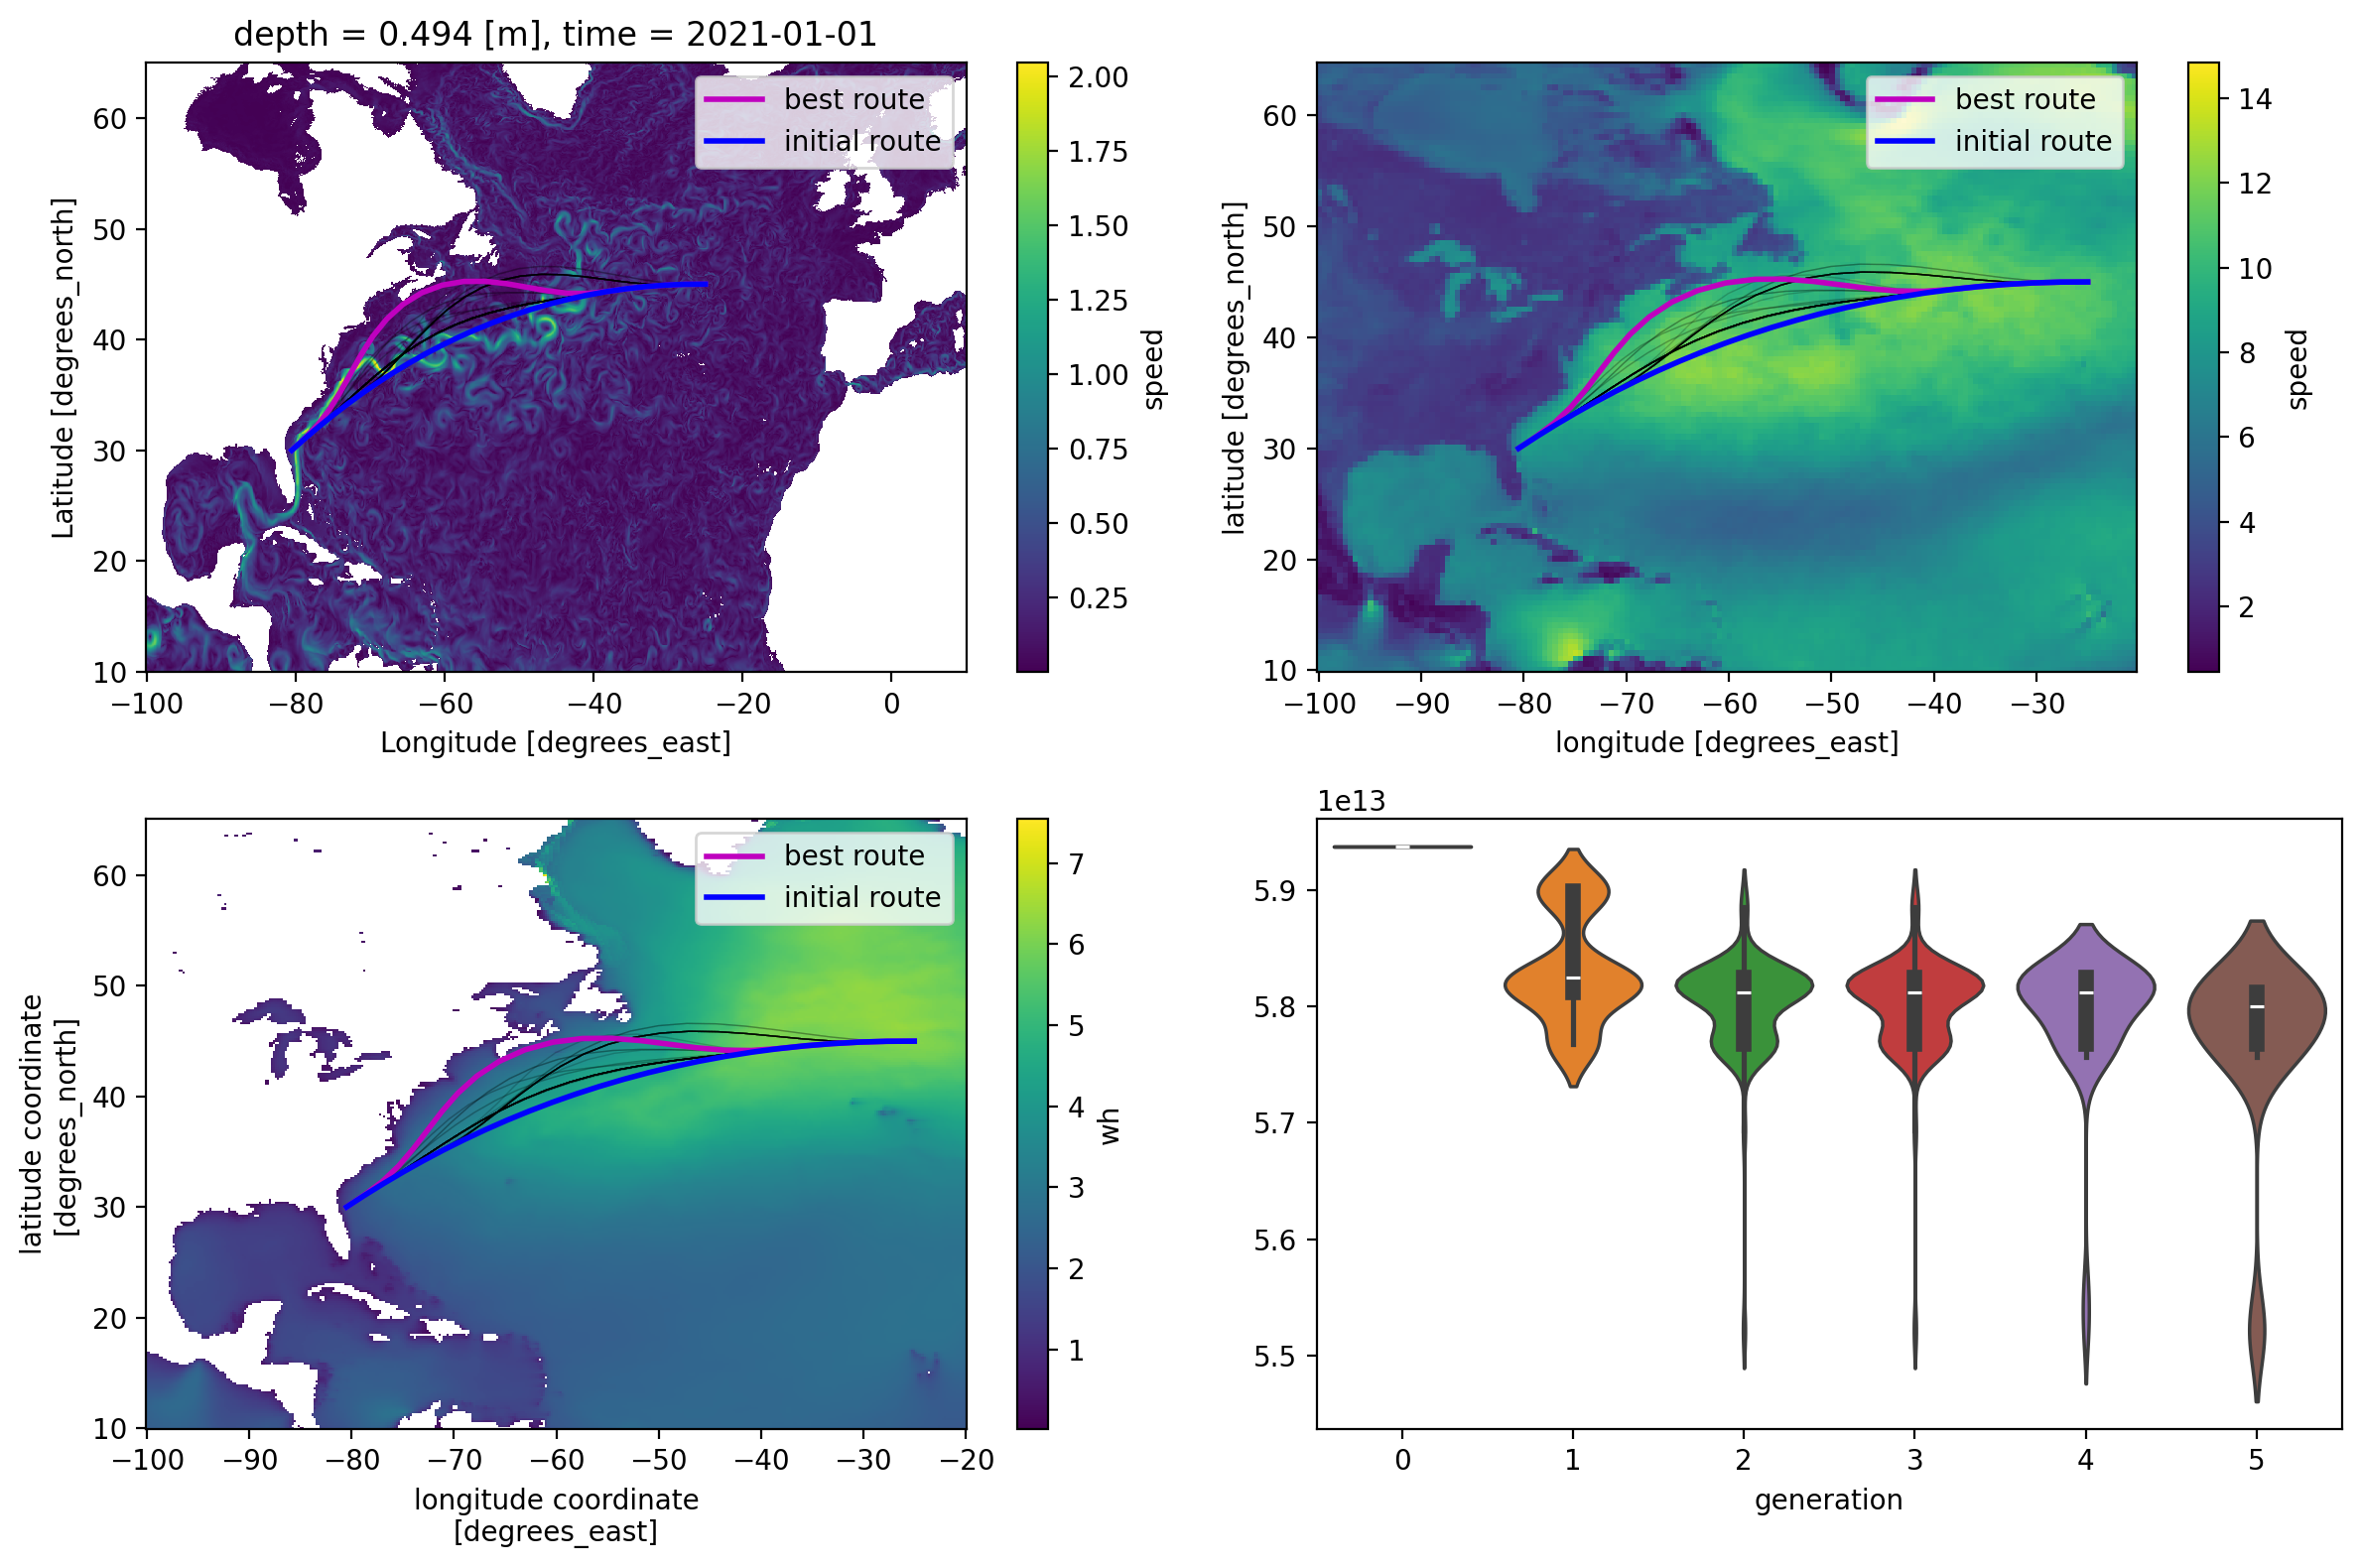

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(12, 8))

ax = ax.flatten()

fig.set_dpi(200)

currents.speed.plot(ax=ax[0])
winds.speed.mean("time").plot(ax=ax[1])
waves.wh.mean("time").plot(ax=ax[2])

for _ax in ax[:-1]:
    for r in routes:
        _ax.plot(*r.line_string.xy, "-k", alpha=0.1, linewidth=0.5)
    _ax.plot(
        *routes[pd.Series(costs).argmin()].line_string.xy,
        "-m",
        label="best route",
        linewidth=2.0,
    )
    _ax.plot(*route_0.line_string.xy, "-b", label="initial route", linewidth=2.0)
    _ax.legend()

sns.violinplot(pd.DataFrame.from_records(cost_records).T, ax=ax[-1])
ax[-1].set_xlabel("generation")

fig.tight_layout();

In [40]:
p_a, p_b = np.random.randint(0, len(routes), size=(2,))
route_a = routes[p_a]
route_b = routes[p_b]

In [41]:
from ship_routing.algorithms import (
    crossover_routes_minimal_cost,
    crossover_routes_random,
)

In [42]:
route_min = crossover_routes_minimal_cost(
    route_0=route_a,
    route_1=route_b,
    current_data_set=currents,
    wind_data_set=winds,
    wave_data_set=waves,
)
route_min

/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Route(way_points=(WayPoint(lon=-80.5, lat=29.99999999999999, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.71122777320231, lat=31.113915728656, time=numpy.datetime64('2021-01-01T02:59:59.999')), WayPoint(lon=-76.97896185450138, lat=32.32347420081359, time=numpy.datetime64('2021-01-01T05:59:59.999')), WayPoint(lon=-75.40192757970625, lat=33.720751465041964, time=numpy.datetime64('2021-01-01T08:59:59.999')), WayPoint(lon=-73.96559039866025, lat=35.27619353063916, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-72.59729001029685, lat=36.9340924985286, time=numpy.datetime64('2021-01-01T14:59:59.999')), WayPoint(lon=-71.18817409016037, lat=38.63180585560498, time=numpy.datetime64('2021-01-01T17:59:59.999')), WayPoint(lon=-69.61251562255026, lat=40.29603055402869, time=numpy.datetime64('2021-01-01T20:59:59.999')), WayPoint(lon=-67.76074822142759, lat=41.84288564603693, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-65.5730112704114, lat=43.17876199

In [43]:
route_rand = crossover_routes_random(
    route_0=route_a,
    route_1=route_b,
)
route_rand

/Users/wrath/micromamba/envs/ship_routing/lib/python3.12/site-packages/shapely/set_operations.py:131: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)


Route(way_points=(WayPoint(lon=-80.5, lat=29.99999999999999, time=numpy.datetime64('2021-01-01')), WayPoint(lon=-78.71122777320231, lat=31.113915728656, time=numpy.datetime64('2021-01-01T02:59:59.999')), WayPoint(lon=-76.97896185450138, lat=32.32347420081359, time=numpy.datetime64('2021-01-01T05:59:59.999')), WayPoint(lon=-75.40192757970625, lat=33.720751465041964, time=numpy.datetime64('2021-01-01T08:59:59.999')), WayPoint(lon=-73.96559039866025, lat=35.27619353063916, time=numpy.datetime64('2021-01-01T11:59:59.999')), WayPoint(lon=-72.59729001029685, lat=36.9340924985286, time=numpy.datetime64('2021-01-01T14:59:59.999')), WayPoint(lon=-71.18817409016037, lat=38.63180585560498, time=numpy.datetime64('2021-01-01T17:59:59.999')), WayPoint(lon=-69.61251562255026, lat=40.29603055402869, time=numpy.datetime64('2021-01-01T20:59:59.999')), WayPoint(lon=-67.76074822142759, lat=41.84288564603693, time=numpy.datetime64('2021-01-01T23:59:59.999')), WayPoint(lon=-65.5730112704114, lat=43.17876199

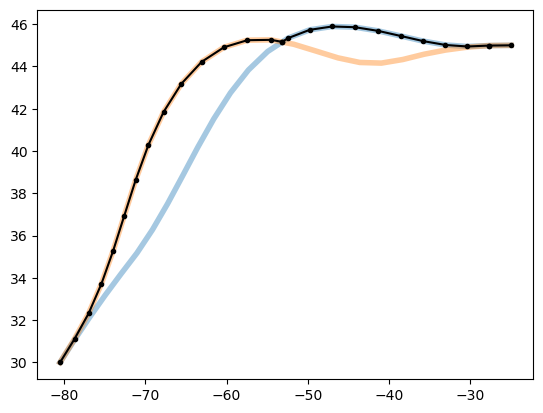

In [44]:
plt.plot(*route_a.line_string.xy, "-", linewidth=4, alpha=0.4)
plt.plot(*route_b.line_string.xy, "-", linewidth=4, alpha=0.4)
plt.plot(*route_min.line_string.xy, "k.-")

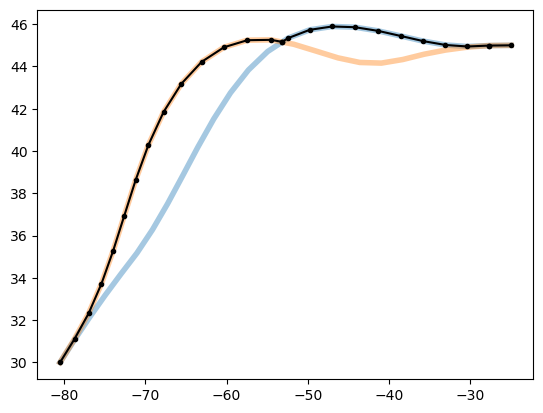

In [45]:
plt.plot(*route_a.line_string.xy, "-", linewidth=4, alpha=0.4)
plt.plot(*route_b.line_string.xy, "-", linewidth=4, alpha=0.4)
plt.plot(*route_rand.line_string.xy, "k.-")

In [46]:
ca = route_a.cost_through(
    current_data_set=currents,
    wind_data_set=winds,
    wave_data_set=waves,
)
cb = route_b.cost_through(
    current_data_set=currents,
    wind_data_set=winds,
    wave_data_set=waves,
)
cm = route_min.cost_through(
    current_data_set=currents,
    wind_data_set=winds,
    wave_data_set=waves,
)
cr = route_rand.cost_through(
    current_data_set=currents,
    wind_data_set=winds,
    wave_data_set=waves,
)

In [47]:
print(cm / (ca * cb) ** 0.5)
print(cr / (ca * cb) ** 0.5)

0.9736213003431854
0.9736213003431854


In [48]:
cm, min(costs)

(54946317986707.85, 55218004907695.516)